In [1]:
import sys

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import datasets, transforms
import torchvision.models as models

import numpy as np
from tqdm import tqdm

import matplotlib.pyplot as plt


In [2]:
batch_size = 128
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# load data
augmentation_transform = transforms.Compose([transforms.Pad(4, fill=0, padding_mode='constant'),
                                             transforms.RandomCrop(32),
                                             transforms.RandomHorizontalFlip(p=0.5),
                                             transforms.ToTensor(),
                                             transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                                             ])

test_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('data/cifar10', train=True, download=True,
                     transform=augmentation_transform),
    batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('data/cifar10', train=False, transform=test_transform),
    batch_size=batch_size * 2, shuffle=True)

Files already downloaded and verified


In [3]:
'''Pre-activation ResNet in PyTorch.

Reference:
[1] Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun
    Identity Mappings in Deep Residual Networks. arXiv:1603.05027
'''


class PreActBlock(nn.Module):
    '''Pre-activation version of the BasicBlock.'''
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(PreActBlock, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)

        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False)
            )

    def forward(self, x):
        out = F.relu(self.bn1(x))
        shortcut = self.shortcut(out) if hasattr(self, 'shortcut') else x
        out = self.conv1(out)
        out = self.conv2(F.relu(self.bn2(out)))
        out += shortcut
        return out


class PreActBottleneck(nn.Module):
    '''Pre-activation version of the original Bottleneck module.'''
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(PreActBottleneck, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion * planes, kernel_size=1, bias=False)

        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False)
            )

    def forward(self, x):
        out = F.relu(self.bn1(x))
        shortcut = self.shortcut(out) if hasattr(self, 'shortcut') else x
        out = self.conv1(out)
        out = self.conv2(F.relu(self.bn2(out)))
        out = self.conv3(F.relu(self.bn3(out)))
        out += shortcut
        return out


class PreActResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(PreActResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def PreActResNet18():
    return PreActResNet(PreActBlock, [2, 2, 2, 2])


def PreActResNet34():
    return PreActResNet(PreActBlock, [3, 4, 6, 3])


def PreActResNet50():
    return PreActResNet(PreActBottleneck, [3, 4, 6, 3])


def PreActResNet101():
    return PreActResNet(PreActBottleneck, [3, 4, 23, 3])


def PreActResNet152():
    return PreActResNet(PreActBottleneck, [3, 8, 36, 3])


model = PreActResNet34()
model.to(device)

pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
pytorch_total_params

21279306

In [4]:
def cos_annealing_lr(initial_lr, cur_epoch, epoch_per_cycle):
    return initial_lr * (np.cos(np.pi * cur_epoch / epoch_per_cycle) + 1) / 2

In [5]:
# Change these params!
n_cycle = 3
initial_lr = 0.2
epochs_per_cycle = 2

lr_record = []
train_loss_record = []
train_acc_record = []

test_loss_record = []
test_acc_record = []

optimizer = optim.SGD(model.parameters(), lr=initial_lr)
criterion = nn.CrossEntropyLoss()

for cycle in range(n_cycle):
    print('Snapshot # {}'.format(cycle + 1))
    for epoch in range(epochs_per_cycle):
        epoch_loss = 0
        total = 0
        correct = 0
        
        lr = cos_annealing_lr(initial_lr, epoch, epochs_per_cycle)
        optimizer.state_dict()['param_groups'][0]['lr'] = lr
        
        print('\nEpoch {} | Learning Rate {}'.format(epoch, lr))
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            _, predicted = torch.max(output.data, 1)
            loss.backward()
            optimizer.step()
            
            total += target.size(0)
            correct += (predicted == target).sum().item()
            epoch_loss += loss.item() / len(train_loader)
            
            sys.stdout.write('\rEpoch {} | Batch # {} Train Loss {:.5f} '.format(epoch, batch_idx, loss.item()))
            
        sys.stdout.write('\rEpoch {} | Epoch Train Loss {:.5f}'.format(epoch, epoch_loss))
        epoch_acc = correct / total * 100
        print('\nEpoch {} | Epoch Train Acc {:.3f}%'.format(epoch, epoch_acc))
        
        lr_record.append(lr)
        train_loss_record.append(epoch_loss)
        train_acc_record.append(epoch_acc)

        # epoch evaluation
        with torch.no_grad():
            test_epoch_loss = 0
            test_total = 0
            test_correct = 0
            
            for batch_idx, (data, target) in enumerate(test_loader):
                data, target = data.to(device), target.to(device)
                
                output = model(data)
                loss = criterion(output, target)
                _, predicted = torch.max(output.data, 1)
                
                test_total += target.size(0)
                test_correct += (predicted == target).sum().item()
                test_epoch_loss += loss.item() / len(test_loader)
                
            test_epoch_acc = test_correct / test_total * 100
            print('Epoch {} | Epoch Test Loss {:.5f}'.format(epoch, test_epoch_loss))
            print('Epoch {} | Epoch Test Acc {:.3f}%'.format(epoch, test_epoch_acc))
            
            test_loss_record.append(test_epoch_loss)
            test_acc_record.append(test_epoch_acc)
            
    # TODO: Save model from each snapshot checkpoint...

Snapshot # 1

Epoch 0 | Learning Rate 0.2
Epoch 0 | Epoch Train Loss 1.79185
Epoch 0 | Epoch Train Acc 33.062%
Epoch 0 | Epoch Test Loss 1.50295
Epoch 0 | Epoch Test Acc 45.570%

Epoch 1 | Learning Rate 0.1
Epoch 1 | Epoch Train Loss 1.27935
Epoch 1 | Epoch Train Acc 53.612%
Epoch 1 | Epoch Test Loss 1.21946
Epoch 1 | Epoch Test Acc 55.920%
Snapshot # 2

Epoch 0 | Learning Rate 0.2
Epoch 0 | Epoch Train Loss 0.92321
Epoch 0 | Epoch Train Acc 67.518%
Epoch 0 | Epoch Test Loss 0.90642
Epoch 0 | Epoch Test Acc 67.990%

Epoch 1 | Learning Rate 0.1
Epoch 1 | Epoch Train Loss 0.71524
Epoch 1 | Epoch Train Acc 75.350%
Epoch 1 | Epoch Test Loss 0.75433
Epoch 1 | Epoch Test Acc 74.930%
Snapshot # 3

Epoch 0 | Learning Rate 0.2
Epoch 0 | Epoch Train Loss 0.59733
Epoch 0 | Epoch Train Acc 79.450%
Epoch 0 | Epoch Test Loss 0.66949
Epoch 0 | Epoch Test Acc 77.400%

Epoch 1 | Learning Rate 0.1
Epoch 1 | Epoch Train Loss 0.51374
Epoch 1 | Epoch Train Acc 82.298%
Epoch 1 | Epoch Test Loss 0.62425
Epoc

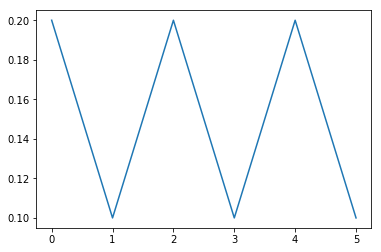

In [6]:
plt.plot([i for i in range(epochs_per_cycle * n_cycle)], lr_record)
plt.show()

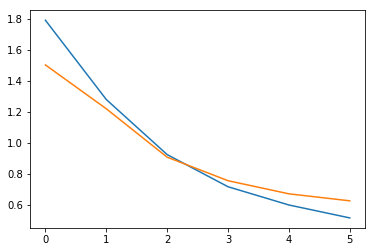

In [7]:
plt.plot([i for i in range(epochs_per_cycle * n_cycle)], train_loss_record)
plt.plot([i for i in range(epochs_per_cycle * n_cycle)], test_loss_record)
plt.show()

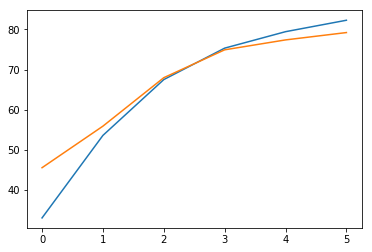

In [8]:
plt.plot([i for i in range(epochs_per_cycle * n_cycle)], train_acc_record)
plt.plot([i for i in range(epochs_per_cycle * n_cycle)], test_acc_record)
plt.show()